In [34]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from tqdm.notebook import tqdm

# Loading & Exploring

In [35]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "RecipeNLG_dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "paultimothymooney/recipenlg",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

<ipython-input-35-4af3177ee35f>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [36]:
#df = pd.read_csv("/kaggle/input/recipenlg/RecipeNLG_dataset.csv")
df.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [37]:
print("The shape of the data:")
df.shape

The shape of the data:


(2231142, 7)

In [38]:
print("The columns names:")
df.columns

The columns names:


Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

# Pre-processing

In [39]:
df['source'].unique()

array(['Gathered', 'Recipes1M'], dtype=object)

In [40]:
df = df.drop(['Unnamed: 0', 'link', 'source'], axis=1)

In [41]:
df.duplicated().sum()

np.int64(0)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   directions   object
 3   NER          object
dtypes: object(4)
memory usage: 68.1+ MB


## Preprocess text in the columns

In [43]:
df.head()

title                                        ingredients  \
0    No-Bake Nut Cookies  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  Jewell Ball'S Chicken  ["1 small jar chipped beef, cut up", "4 boned ...   
2            Creamy Corn  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3          Chicken Funny  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4   Reeses Cups(Candy)    ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [44]:
df_clean = df.copy()

### Title column

In [45]:
df['title']

0                                    No-Bake Nut Cookies
1                                  Jewell Ball'S Chicken
2                                            Creamy Corn
3                                          Chicken Funny
4                                   Reeses Cups(Candy)  
                               ...                      
2231137                              Sunny's Fake Crepes
2231138                                       Devil Eggs
2231139    Extremely Easy and Quick - Namul Daikon Salad
2231140       Pan-Roasted Pork Chops With Apple Fritters
2231141                   Polpette in Spicy Tomato Sauce
Name: title, Length: 2231142, dtype: object

In [46]:
def clean_title(text):
    if isinstance(text, float):  # check for NaN
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

In [47]:
df_clean['title'] = df['title'].apply(clean_title)

In [48]:
df_clean['title']

0                                   nobake nut cookies
1                                 jewell balls chicken
2                                          creamy corn
3                                        chicken funny
4                                     reeses cupscandy
                              ...                     
2231137                             sunnys fake crepes
2231138                                     devil eggs
2231139    extremely easy and quick namul daikon salad
2231140      panroasted pork chops with apple fritters
2231141                 polpette in spicy tomato sauce
Name: title, Length: 2231142, dtype: object

### Ingredients Column

In [49]:
df['ingredients']

0          ["1 c. firmly packed brown sugar", "1/2 c. eva...
1          ["1 small jar chipped beef, cut up", "4 boned ...
2          ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...
3          ["1 large whole chicken", "2 (10 1/2 oz.) cans...
4          ["1 c. peanut butter", "3/4 c. graham cracker ...
                                 ...                        
2231137    ["1/2 cup chocolate hazelnut spread (recommend...
2231138    ["1 dozen eggs", "1 paprika", "1 salt and pepp...
2231139    ["150 grams Daikon radish", "1 tbsp Sesame oil...
2231140    ["1 cup apple cider", "6 tablespoons sugar", "...
2231141    ["1 pound ground veal", "1/2 pound sweet Itali...
Name: ingredients, Length: 2231142, dtype: object

In [50]:
import ast

def clean_ingredient_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s./]", "", text)  # keep words, spaces, dots, and slashes
    text = re.sub(r"\s+", " ", text).strip()
    return text

def process_ingredients(ingredients):
    if isinstance(ingredients, float):
        return ""
    ingredients = ast.literal_eval(ingredients)
    ingredients = [clean_ingredient_text(i) for i in ingredients]
    return ", ".join(ingredients)

In [51]:
df_clean['ingredients'] = df['ingredients'].apply(process_ingredients)

In [52]:
df_clean['ingredients']

0          1 c. firmly packed brown sugar, 1/2 c. evapora...
1          1 small jar chipped beef cut up, 4 boned chick...
2          2 16 oz. pkg. frozen corn, 1 8 oz. pkg. cream ...
3          1 large whole chicken, 2 10 1/2 oz. cans chick...
4          1 c. peanut butter, 3/4 c. graham cracker crum...
                                 ...                        
2231137    1/2 cup chocolate hazelnut spread recommended ...
2231138    1 dozen eggs, 1 paprika, 1 salt and pepper to ...
2231139    150 grams daikon radish, 1 tbsp sesame oil, 1 ...
2231140    1 cup apple cider, 6 tablespoons sugar, 4 tabl...
2231141    1 pound ground veal, 1/2 pound sweet italian s...
Name: ingredients, Length: 2231142, dtype: object

### Directions Column

In [53]:
df['directions']

0          ["In a heavy 2-quart saucepan, mix brown sugar...
1          ["Place chipped beef on bottom of baking dish....
2          ["In a slow cooker, combine all ingredients. C...
3          ["Boil and debone chicken.", "Put bite size pi...
4          ["Combine first four ingredients and press in ...
                                 ...                        
2231137    ["Spread hazelnut spread on 1 side of each tor...
2231138    ["Boil eggs on medium for 30mins.", "Then cool...
2231139    ["Julienne the daikon and squeeze out the exce...
2231140    ["In a large bowl, mix the apple cider with 4 ...
2231141    ["Preheat the oven to 350.", "In a bowl, mix t...
Name: directions, Length: 2231142, dtype: object

In [54]:
def clean_direction_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s.,:;!?'-]", "", text)  # keep useful punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

def process_directions(directions):
    if isinstance(directions, float):
        return ""
    directions = ast.literal_eval(directions)  # convert string to list
    directions = [clean_direction_text(i) for i in directions]
    return " ".join(directions)  # join with space between steps

In [55]:
df_clean['directions'] = df['directions'].apply(process_directions)

In [56]:
df_clean['directions']

0          in a heavy 2-quart saucepan, mix brown sugar, ...
1          place chipped beef on bottom of baking dish. p...
2          in a slow cooker, combine all ingredients. cov...
3          boil and debone chicken. put bite size pieces ...
4          combine first four ingredients and press in 13...
                                 ...                        
2231137    spread hazelnut spread on 1 side of each torti...
2231138    boil eggs on medium for 30mins. then cool eggs...
2231139    julienne the daikon and squeeze out the excess...
2231140    in a large bowl, mix the apple cider with 4 cu...
2231141    preheat the oven to 350. in a bowl, mix the ve...
Name: directions, Length: 2231142, dtype: object

### NER Column

In [57]:
df['NER']

0          ["brown sugar", "milk", "vanilla", "nuts", "bu...
1          ["beef", "chicken breasts", "cream of mushroom...
2          ["frozen corn", "cream cheese", "butter", "gar...
3          ["chicken", "chicken gravy", "cream of mushroo...
4          ["peanut butter", "graham cracker crumbs", "bu...
                                 ...                        
2231137    ["chocolate hazelnut spread", "tortillas", "bu...
2231138    ["eggs", "paprika", "salt", "choice", "miracle...
2231139    ["radish", "Sesame oil", "White sesame seeds",...
2231140    ["apple cider", "sugar", "kosher salt", "bay l...
2231141    ["ground veal", "sausage", "bread crumbs", "mi...
Name: NER, Length: 2231142, dtype: object

In [58]:
df_clean['NER'] = [d.lower() for d in df["NER"]]

In [59]:
df_clean['NER']

0          ["brown sugar", "milk", "vanilla", "nuts", "bu...
1          ["beef", "chicken breasts", "cream of mushroom...
2          ["frozen corn", "cream cheese", "butter", "gar...
3          ["chicken", "chicken gravy", "cream of mushroo...
4          ["peanut butter", "graham cracker crumbs", "bu...
                                 ...                        
2231137    ["chocolate hazelnut spread", "tortillas", "bu...
2231138    ["eggs", "paprika", "salt", "choice", "miracle...
2231139    ["radish", "sesame oil", "white sesame seeds",...
2231140    ["apple cider", "sugar", "kosher salt", "bay l...
2231141    ["ground veal", "sausage", "bread crumbs", "mi...
Name: NER, Length: 2231142, dtype: object

### Clean Columns

In [60]:
title_punctuations = ingredients_punctuations = list(
    filter(
        lambda t: all(c in string.punctuation for c in t),
        df_clean["title"]
    )
)

ingredients_punctuations = list(
    filter(
        lambda t: all(c in string.punctuation for c in t),
        df_clean["ingredients"]
    )
)

directions_punctuations = list(
    filter(
        lambda t: all(c in string.punctuation for c in t),
        df_clean["directions"]
    )
)

ner_punctuations = list(
    filter(
        lambda t: all(c in string.punctuation for c in t),
        df_clean["NER"]
    )
)

In [61]:
print('Titles Punctuations:\n', title_punctuations)
print('Ingredients Punctuations:\n', ingredients_punctuations)
print('Direction Punctuations:\n', directions_punctuations)
print('NER Punctuations:\n', ner_punctuations)

Titles Punctuations:
 ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Ingredients Punctuations:
 ['.', '.', '.', '.', '..................................................................']
Direction Punctuations:
 ['..................................................................', '.', '.', ':', '.']
NER Punctuations:
 ['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]',

In [62]:
from tqdm.notebook import tqdm

title_clean = [t for t in tqdm(df_clean["title"]) if t not in title_punctuations]
ingredients_clean = [t for t in tqdm(df_clean["ingredients"]) if t not in ingredients_punctuations]
directions_clean = [t for t in tqdm(df_clean["directions"]) if t not in directions_punctuations]
ner_clean = [t for t in tqdm(df_clean["NER"]) if t not in ner_punctuations]

  0%|          | 0/2231142 [00:00<?, ?it/s]

  0%|          | 0/2231142 [00:00<?, ?it/s]

  0%|          | 0/2231142 [00:00<?, ?it/s]

  0%|          | 0/2231142 [00:00<?, ?it/s]

In [ ]:
# Get the indices of clean ingredients, directions, ner based on original df_clean
ingredients_indices = [i for i, t in enumerate(df_clean["ingredients"]) if t not in ingredients_punctuations]
directions_indices = [i for i, t in enumerate(df_clean["directions"]) if t not in directions_punctuations]
ner_indices = [i for i, t in enumerate(df_clean["NER"]) if t not in ner_punctuations]

# Clustering

## Based on title

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
title_vectors = tfidf_vectorizer.fit_transform(title_clean)
print("TF-IDF shape:", title_vectors.shape)

TF-IDF shape: (2231099, 1000)


#### K-means

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
title_cluster_tfidf_kmeans = kmeans.fit_predict(title_vectors)

<ipython-input-34-9d52e2684e29>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=title_cluster_tfidf_kmeans, palette='tab10')


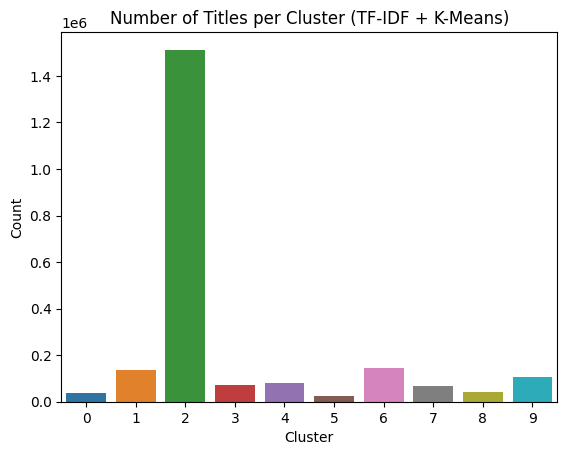

In [ ]:
sns.countplot(x=title_cluster_tfidf_kmeans, palette='tab10')
plt.title('Number of Titles per Cluster (TF-IDF + K-Means)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

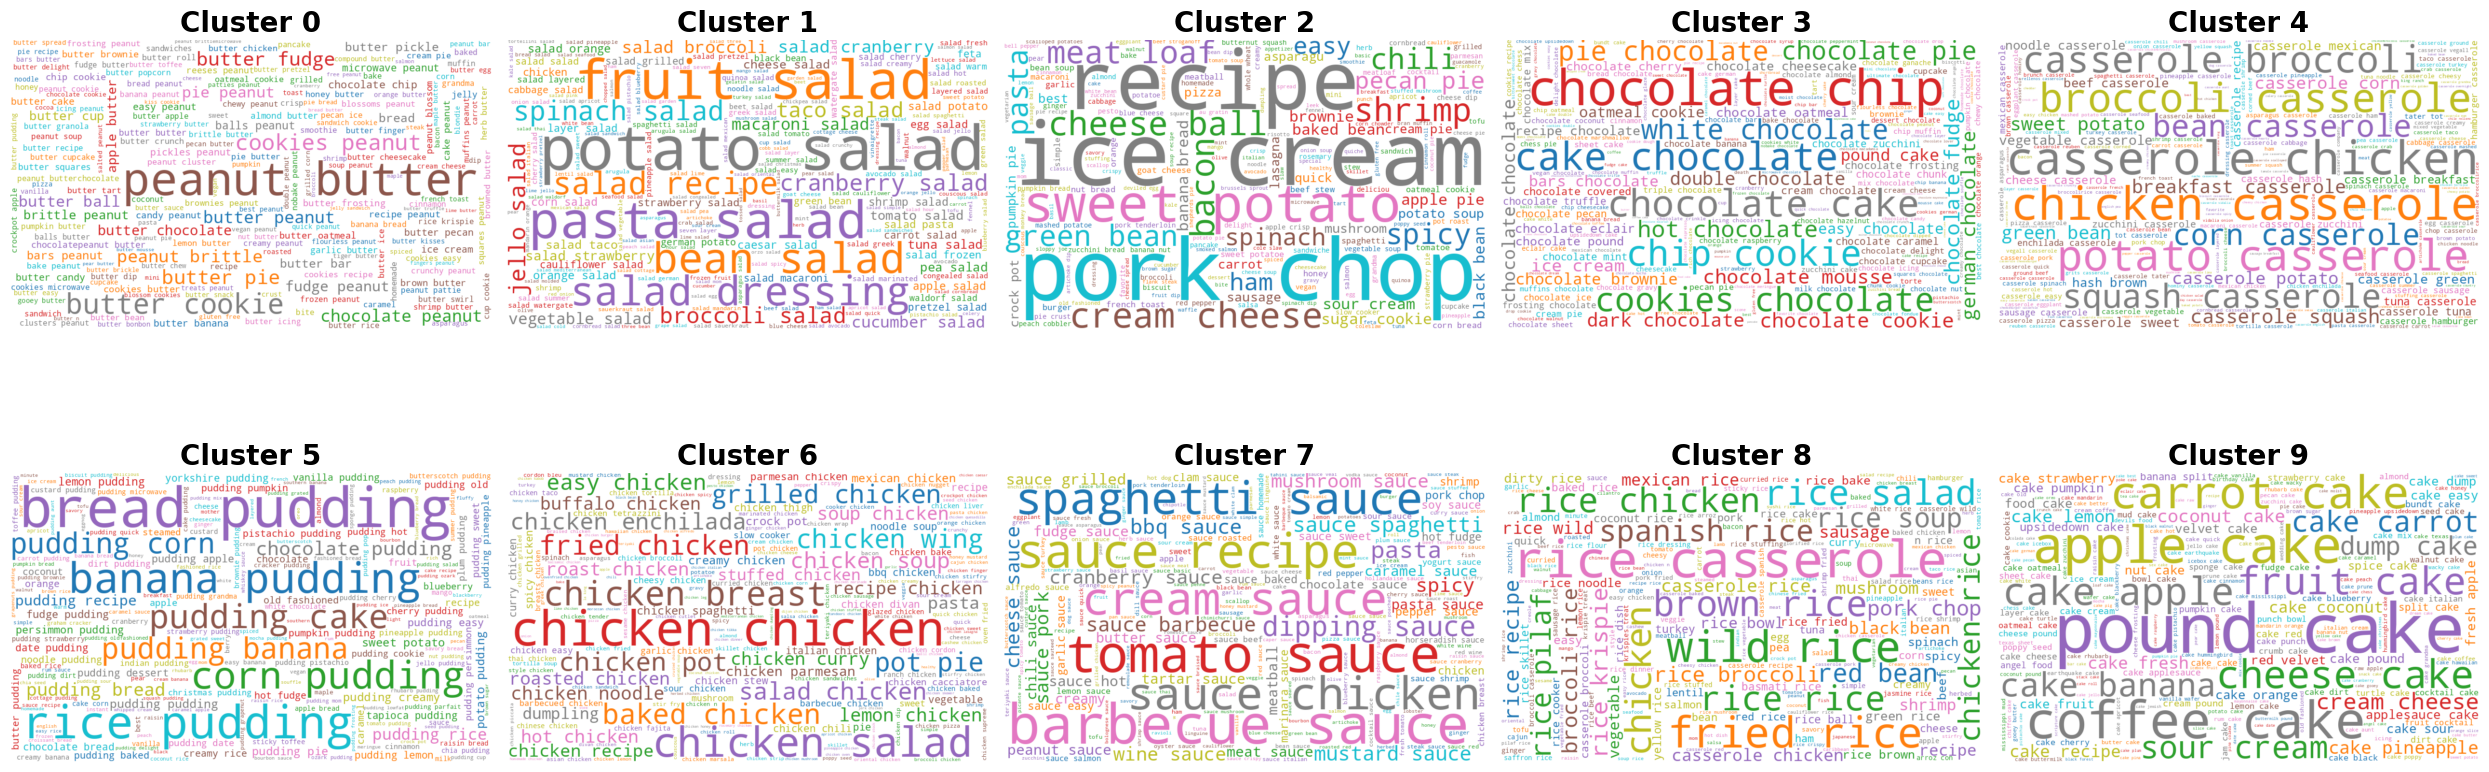

In [ ]:
# Create figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 cols
axes = axes.flatten()  # Flatten to loop easily

for idx, cluster in enumerate(sorted(set(title_cluster_tfidf_kmeans))):
    # Get indexes of samples in this cluster
    indices = [i for i, label in enumerate(title_cluster_tfidf_kmeans) if label == cluster]

    # Collect titles from those indexes
    cluster_titles = [title_clean[i] for i in indices]

    # Join into text
    text = " ".join(cluster_titles)

    # Generate WordCloud
    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10').generate(text)

    # Plot in grid
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=20, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

#### Agglomerative Hierarchical Clustering

In [ ]:
"""agglo = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
title_cluster_tfidf_agglo = agglo.fit_predict(title_vectors)

sns.countplot(x=title_cluster_tfidf_agglo, palette='tab10')
plt.title('Number of Titles per Cluster (TF-IDF + Hierarchical Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()"""

"agglo = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')\ntitle_cluster_tfidf_agglo = agglo.fit_predict(title_vectors)\n\nsns.countplot(x=title_cluster_tfidf_agglo, palette='tab10')\nplt.title('Number of Titles per Cluster (TF-IDF + Hierarchical Clustering)')\nplt.xlabel('Cluster')\nplt.ylabel('Count')\nplt.show()"

In [ ]:
"""# Create figure
fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 cols
axes = axes.flatten()  # Flatten to loop easily

for idx, cluster in enumerate(sorted(set(title_cluster_tfidf_agglo))):
    # Get indexes of samples in this cluster
    indices = [i for i, label in enumerate(title_cluster_tfidf_agglo) if label == cluster]

    # Collect titles from those indexes
    cluster_titles = [title_clean[i] for i in indices]

    # Join into text
    text = " ".join(cluster_titles)

    # Generate WordCloud
    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10').generate(text)

    # Plot in grid
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=20)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()"""

'# Create figure\nfig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 cols\naxes = axes.flatten()  # Flatten to loop easily\n\nfor idx, cluster in enumerate(sorted(set(title_cluster_tfidf_agglo))):\n    # Get indexes of samples in this cluster\n    indices = [i for i, label in enumerate(title_cluster_tfidf_agglo) if label == cluster]\n    \n    # Collect titles from those indexes\n    cluster_titles = [title_clean[i] for i in indices]\n    \n    # Join into text\n    text = " ".join(cluster_titles)\n    \n    # Generate WordCloud\n    wordcloud = WordCloud(width=1000, height=600, background_color=\'white\', colormap=\'tab10\').generate(text)\n    \n    # Plot in grid\n    axes[idx].imshow(wordcloud, interpolation=\'bilinear\')\n    axes[idx].set_title(f\'Cluster {cluster}\', fontsize=20)\n    axes[idx].axis(\'off\')\n\nplt.tight_layout()\nplt.show()'

### BERT

In [ ]:
import random
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Set seed for reproducibility
random.seed(42)

# Get 10,000 random indices
sample_idx = random.sample(range(len(title_clean)), 25000)

# Create your sampled titles
title_clean_sample = [title_clean[i] for i in sample_idx]

title_embeddings = model.encode(title_clean_sample, show_progress_bar=True)
print("Embeddings shape:", title_embeddings.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Embeddings shape: (25000, 384)


#### K-means

In [ ]:
kmeans_bert = KMeans(n_clusters=10, random_state=42, n_init=10)
title_cluster_bert_kmeans = kmeans_bert.fit_predict(title_embeddings)

<ipython-input-40-b72f98263de8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=title_cluster_bert_kmeans, palette='tab10')


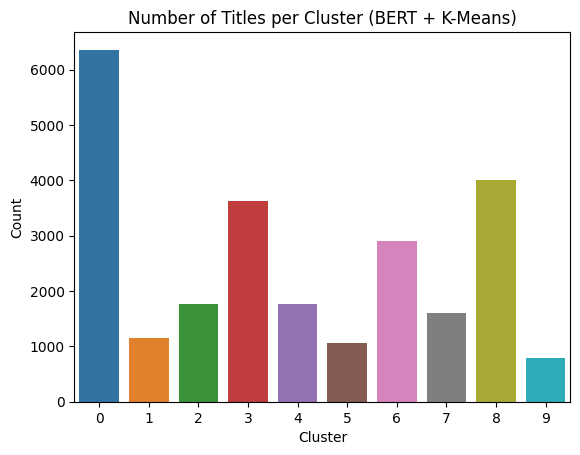

In [ ]:
sns.countplot(x=title_cluster_bert_kmeans, palette='tab10')
plt.title('Number of Titles per Cluster (BERT + K-Means)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

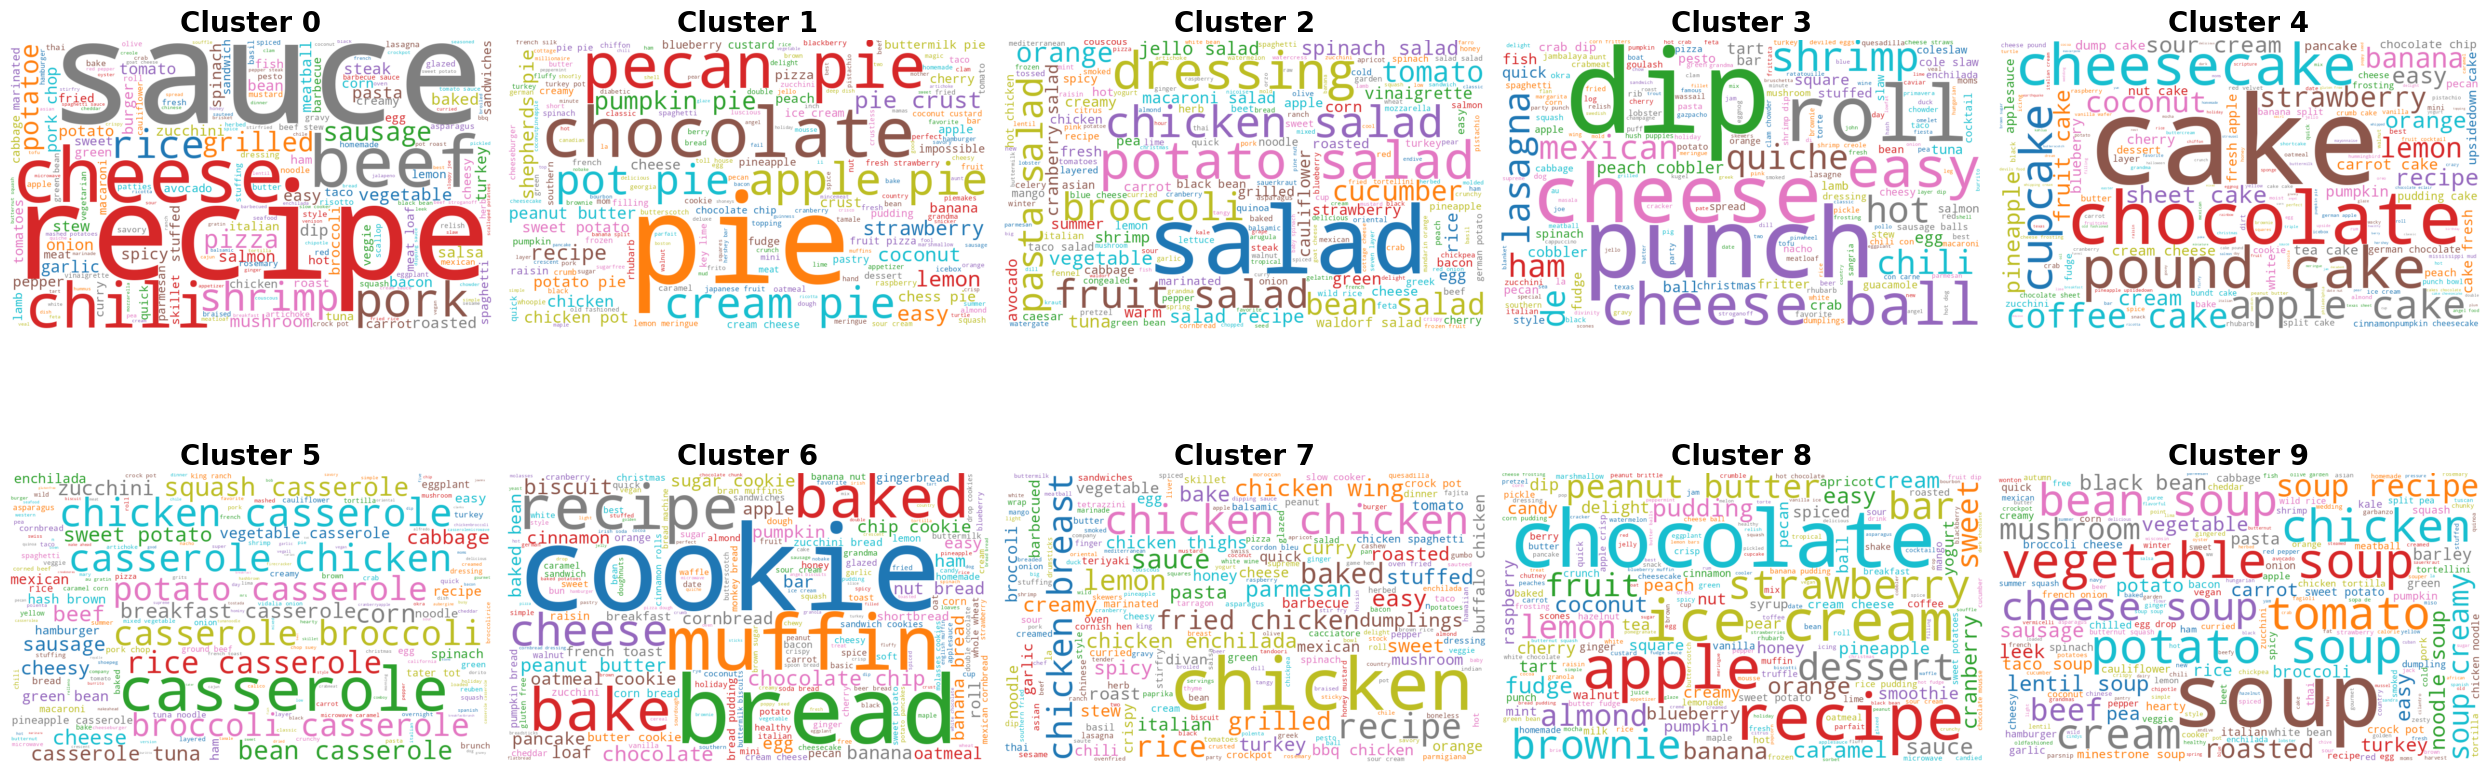

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, cluster in enumerate(sorted(set(title_cluster_bert_kmeans))):
    indices = [i for i, label in enumerate(title_cluster_bert_kmeans) if label == cluster]
    cluster_titles = [title_clean_sample[i] for i in indices]
    text = " ".join(cluster_titles)

    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10').generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=20, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Agglomerative Hierarchical Clustering

In [ ]:
# Select 5000 random indices
sample_idx = random.sample(range(len(title_embeddings)), 5000)

# Sample the embeddings and the corresponding titles
title_embeddings_sample = np.array([title_embeddings[i] for i in sample_idx])
title_clean_sample_5k = [title_clean[i] for i in sample_idx]

agglo = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
title_cluster_bert_agglo = agglo.fit_predict(title_embeddings_sample)

<ipython-input-43-e3639725ad22>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=title_cluster_bert_agglo, palette='tab10')


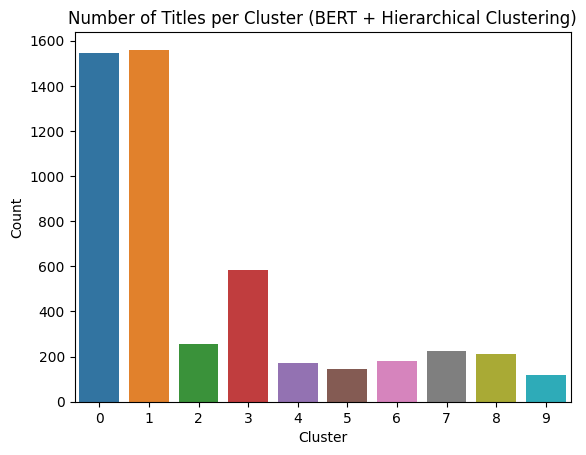

In [ ]:
sns.countplot(x=title_cluster_bert_agglo, palette='tab10')
plt.title('Number of Titles per Cluster (BERT + Hierarchical Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

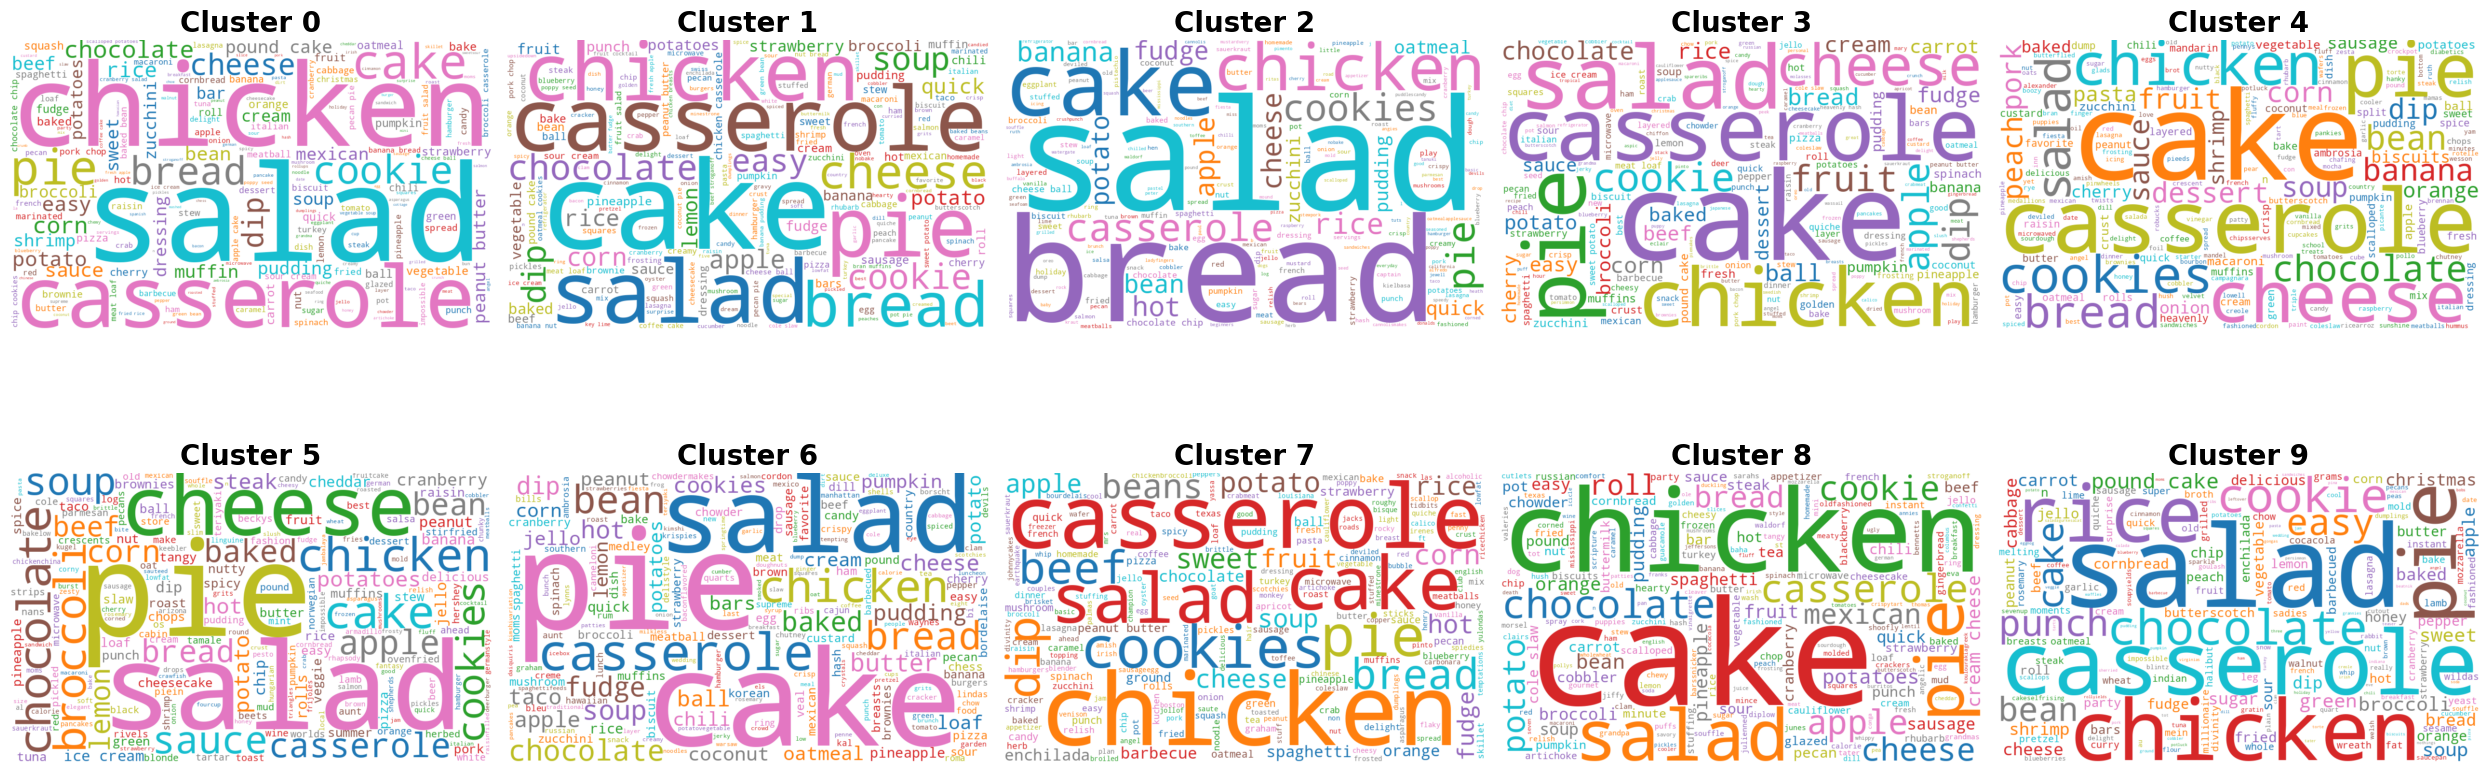

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, cluster in enumerate(sorted(set(title_cluster_bert_agglo))):
    indices = [i for i, label in enumerate(title_cluster_bert_agglo) if label == cluster]
    cluster_titles = [title_clean_sample_5k[i] for i in indices]
    text = " ".join(cluster_titles)

    wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='tab10').generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=20, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Evaluate

This literally took forever.

In [ ]:
from sklearn.metrics import silhouette_score

print("=== TF-IDF Clustering Evaluation ===")
"""try:
    tfidf_kmeans_score = silhouette_score(title_vectors, title_cluster_tfidf_kmeans)
    print(f"TF-IDF + KMeans Silhouette Score: {tfidf_kmeans_score:.4f}")
except Exception as e:
    print("TF-IDF + KMeans evaluation failed:", e)"""

"""try:
    tfidf_agglo_score = silhouette_score(title_vectors.toarray(), title_cluster_tfidf_agglo)
    print(f"TF-IDF + Agglomerative Silhouette Score: {tfidf_agglo_score:.4f}")
except Exception as e:
    print("TF-IDF + Agglomerative evaluation failed:", e)"""

print("\n=== BERT Clustering Evaluation (sample of 50k) ===")
try:
    bert_kmeans_score = silhouette_score(title_embeddings, title_cluster_bert_kmeans)
    print(f"BERT + KMeans Silhouette Score: {bert_kmeans_score:.4f}")
except Exception as e:
    print("BERT + KMeans evaluation failed:", e)

try:
    bert_agglo_score = silhouette_score(title_embeddings_sample, title_cluster_bert_agglo)
    print(f"BERT + Agglomerative Silhouette Score: {bert_agglo_score:.4f}")
except Exception as e:
    print("BERT + Agglomerative evaluation failed:", e)


=== TF-IDF Clustering Evaluation ===

=== BERT Clustering Evaluation (sample of 50k) ===
BERT + KMeans Silhouette Score: 0.0299
BERT + Agglomerative Silhouette Score: -0.0058


## Based on ingredients

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
ingredients_vectors = tfidf_vectorizer.fit_transform(ingredients_clean)  # sparse matrix

print("TF-IDF shape (Ingredients):", ingredients_vectors.shape)

#### K-means

In [32]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
ingredients_cluster_kmeans = kmeans.fit_predict(ingredients_vectors)

sns.countplot(x=ingredients_cluster_kmeans, palette='tab10')
plt.title('Cluster Sizes (Ingredients TF-IDF + KMeans)')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

NameError: name 'ingredients_vectors' is not defined

NameError: name 'ingredients_cluster_kmeans' is not defined

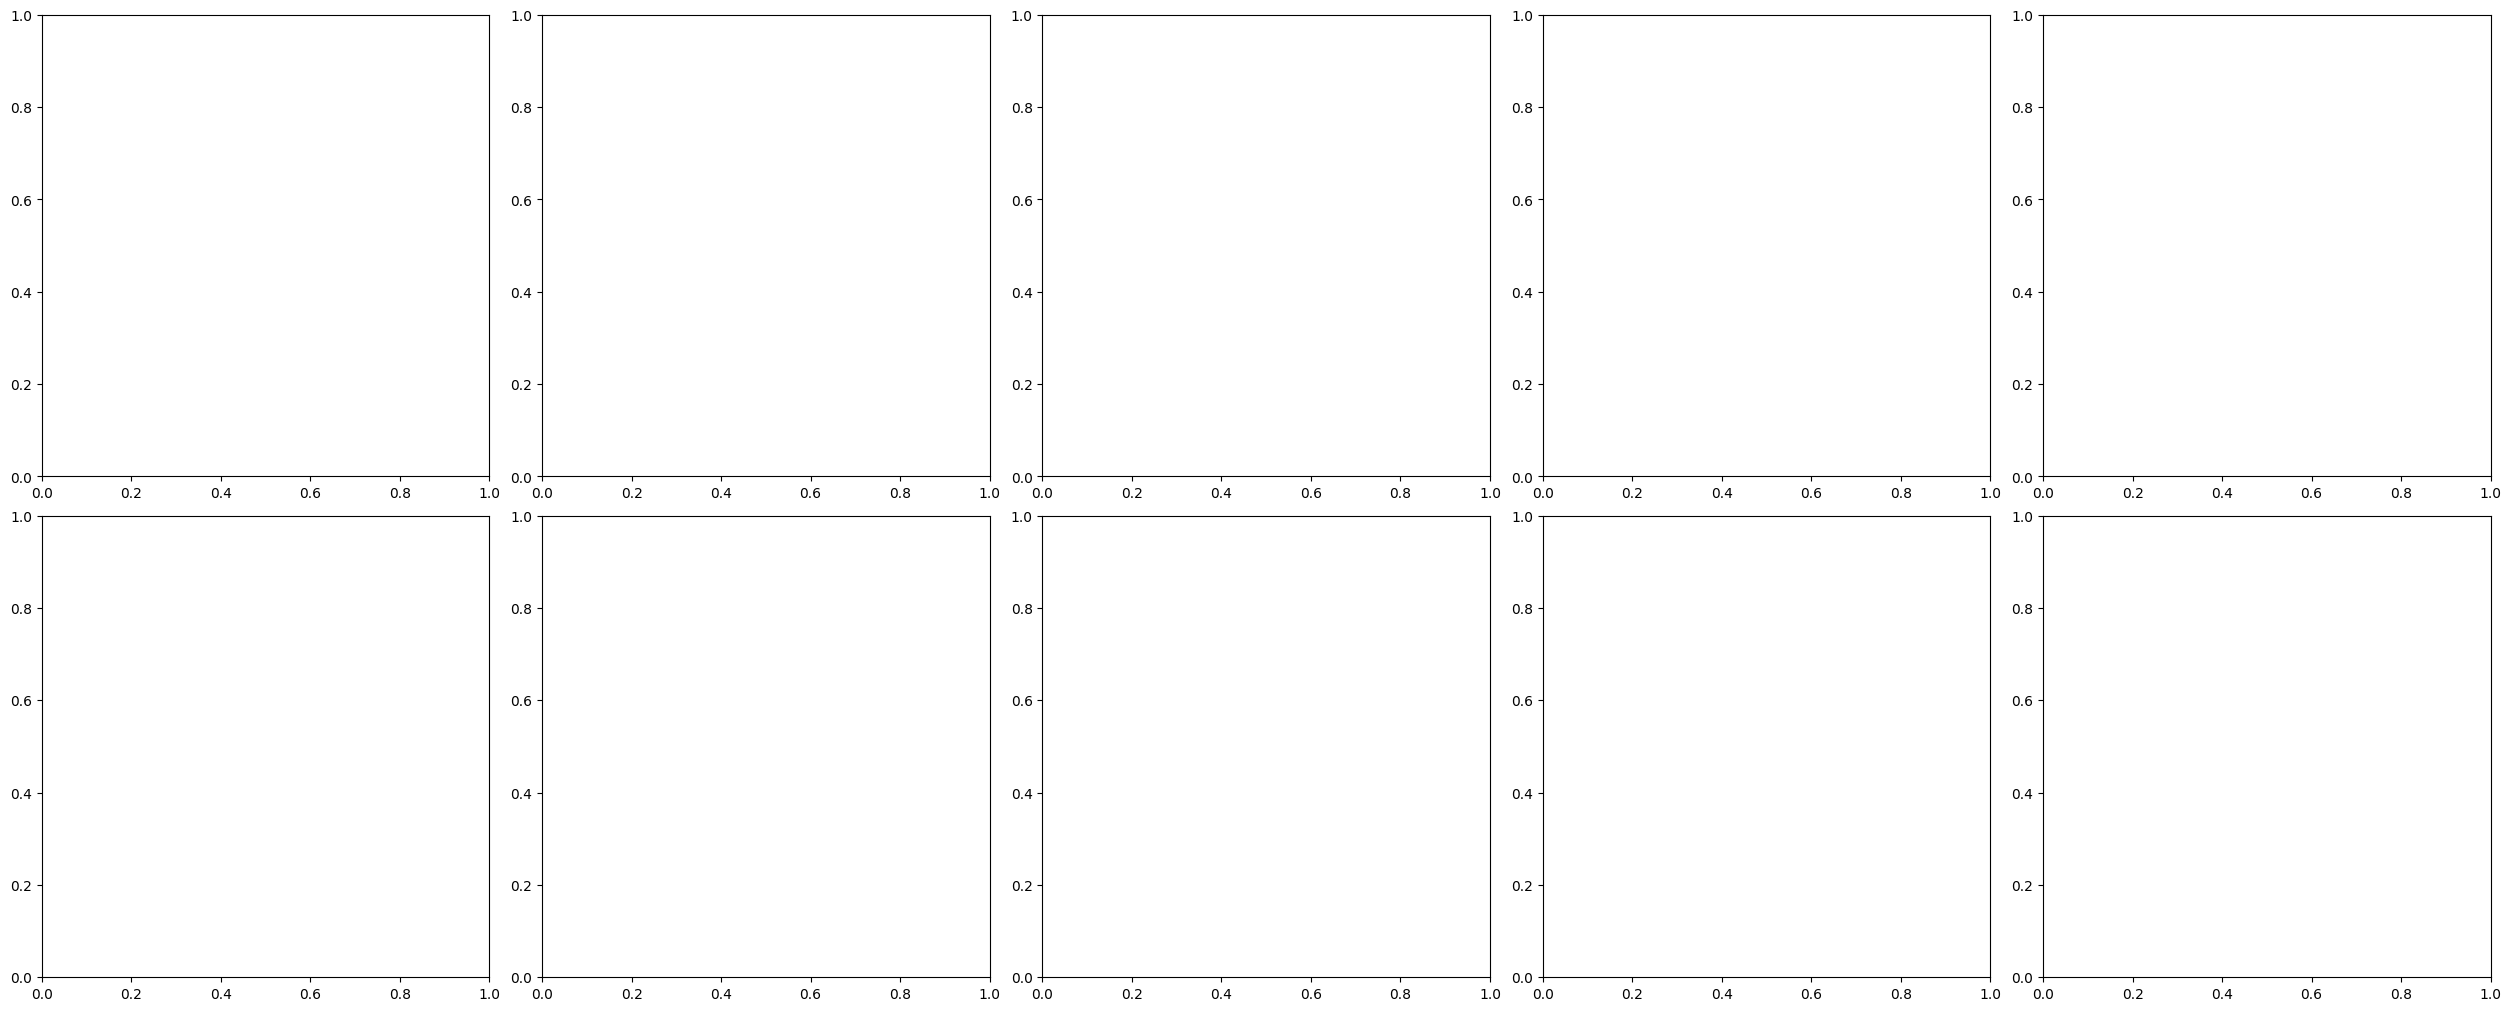

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)
axes = axes.flatten()

for idx, cluster in enumerate(sorted(set(ingredients_cluster_kmeans))):
    indices = [i for i, label in enumerate(ingredients_cluster_kmeans) if label == cluster]

    # Get titles based on original df_clean indices
    titles = [df_clean.loc[ingredients_indices[i], "title"] for i in indices]

    # Join all titles (no limit)
    text = " ".join(titles)

    wordcloud = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='tab10',
        max_words=300  # control wordcloud clutter only
    ).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=20, fontweight='bold')
    axes[idx].axis('off')

plt.show()

### BERT

#### K-means

#### Hierarchical Clustering